📌 Trabajo Final de Diplomatura en Inteligencia Artificial - Grupo 6 - Cohorte  2024

# Sistema para la clasificación correcta de residuos.


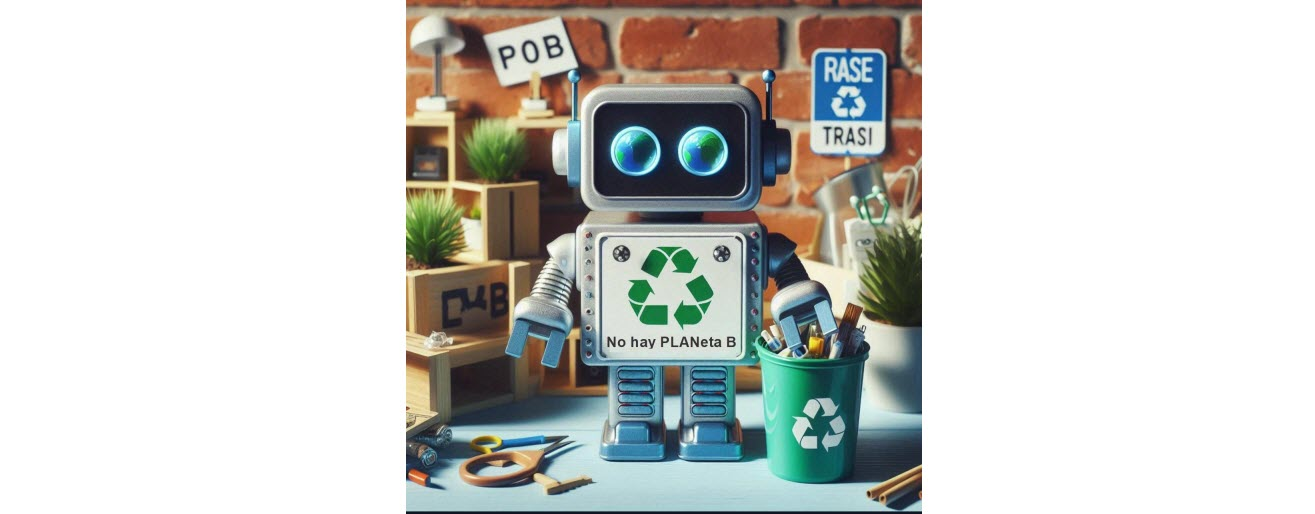

### Integrantes:  
    Valentina Botta  
    Gustavo Lucarella   
    Mauricio Magistocchi   
    Edgardo Eliseo Cornelio  


 **🟢 "En este cuaderno, clasificaremos los desechos (trash) o no, utilizando una Red Neuronal Convolucional (CNN).".**


El desperdicio es un problema global significativo. Se están generando volúmenes crecientes de residuos a medida que la población mundial y los estándares de vida aumentan. Las personas están cada vez más preocupadas por la producción de residuos y su efecto, y buscan formas de abordar el problema.

El reciclaje es el proceso de convertir materiales de desecho en nuevos materiales y objetos. La recuperación de energía de los materiales de desecho a menudo se incluye en este concepto. La reciclabilidad de un material depende de su capacidad para recuperar las propiedades que tenía en su estado original. Es una alternativa a la eliminación de residuos "convencional" que puede ahorrar materiales y ayudar a reducir las emisiones de gases de efecto invernadero. El reciclaje puede prevenir el desperdicio de materiales potencialmente útiles y reducir el consumo de materias primas frescas, lo que a su vez disminuye: el uso de energía, la contaminación del aire (por incineración) y la contaminación del agua (por vertederos).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, _ in os.walk('/MyDrive/kaggle/input'):
        print(dirname)

In [2]:
train_path = "/mnt/c/Users/edgardo/git-edgardo/Austral/TF-Diplo/DataSet/Dataset_splits/train"
test_path = "/mnt/c/Users/edgardo/git-edgardo/Austral/TF-Diplo/DataSet/Dataset_splits/test"

In [3]:
contenido = os.listdir(train_path)
print(contenido)

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Importamos librerias

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model
from glob import glob
# mejoras
from tensorflow.keras.regularizers import l2
#tf.get_logger().setLevel('ERROR') # solo mostramos mensajes de tipo "ERROR"

2024-10-27 12:49:07.527808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 12:49:07.540197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 12:49:07.543625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 12:49:07.552614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 12:49:08.643957: W tensorflow/compiler/tf2

##  Carga y Preprocesamiento de Imágenes desde Directorios

Leemos imágenes de una ruta de directorio, convertirmos a formato RGB, almacenamos las imágenes en un array y también capturamos sus etiquetas. Al final, toda esta información (imágenes y etiquetas) se organiza en un DataFrame de pandas para su uso posterior en un modelo de aprendizaje automático

In [5]:
x_data = []
y_data = []

for category in glob(train_path+'/*'):                              # Itera sobre las carpetas de cada categoría
    for file in tqdm(glob(category+'/*')):                          # Itera sobre los archivos de cada categoría, con tqdm muestro barra de avance
        img_array=cv2.imread(file)                                  # Carga la imagen
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)      # Convierte la imagen de BGR a RGB
        x_data.append(img_array)                                    # Agrega la imagen a la lista x_data
        y_data.append(category.split("/")[-1])                      # Extrae y agrega la etiqueta a y_data

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:05<00:00, 179.40it/s]


Vemos la estructura del dataframe data como (n filas, n columnas)

In [6]:
data.shape

(7117, 2)

In [24]:
# data['label'].value_counts()
data['image']

0       [[[136, 131, 128], [140, 135, 132], [143, 138,...
1       [[[254, 255, 249], [251, 252, 246], [246, 247,...
2       [[[59, 46, 30], [53, 40, 24], [54, 42, 28], [5...
3       [[[28, 37, 18], [18, 27, 8], [40, 47, 29], [23...
4       [[[15, 15, 13], [25, 25, 23], [12, 10, 13], [1...
                              ...                        
7112    [[[231, 231, 231], [231, 231, 231], [231, 231,...
7113    [[[255, 255, 255], [255, 255, 255], [255, 255,...
7114    [[[255, 255, 255], [255, 255, 255], [255, 255,...
7115    [[[255, 255, 255], [255, 255, 255], [255, 255,...
7116    [[[255, 255, 255], [255, 255, 255], [255, 255,...
Name: image, Length: 7117, dtype: object

Importamos Counter para obtener la cantidad (frecuencia) de imagenes por categoria

In [7]:
from collections import Counter
Counter(y_data)

Counter({'compost': 1093,
         'glass': 1084,
         'paper': 1084,
         'trash': 1036,
         'cardboard': 1013,
         'plastic': 969,
         'metal': 838})

Mostramos mediante un grafico de torta el porcentaje de distribucion por categoria de las imagenes

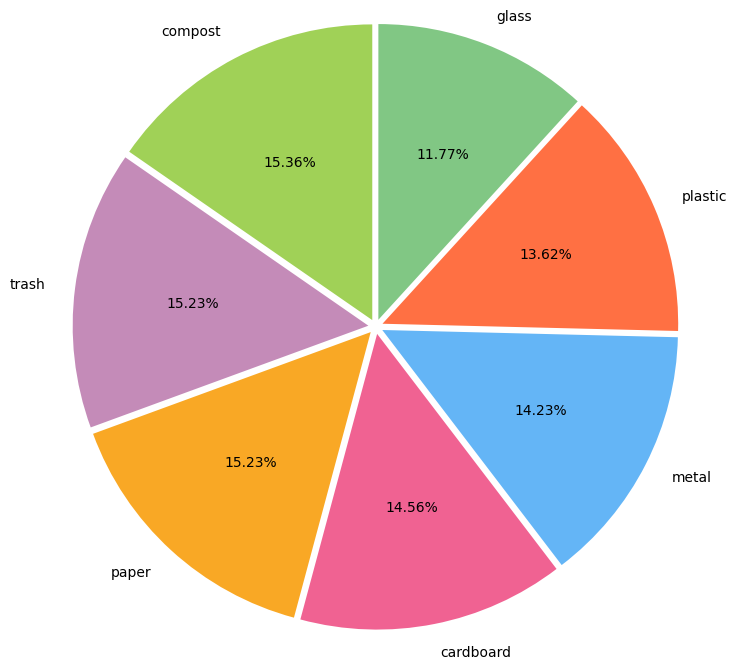

In [8]:
colors = ['#a0d157', '#c48bb8', '#f9a825', '#f06292', '#64b5f6', '#ff7043', '#81c784']
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]  # Añadir un valor para cada categoría

plt.pie(data.label.value_counts(), startangle=90, explode=explode, autopct='%0.2f%%',
        labels=['compost', 'trash' , 'paper' , 'cardboard' , 'metal', 'plastic', 'glass' ], colors=colors, radius=2)

plt.show()


Mostramos nueve imagenes del dataset de manera aleatoria

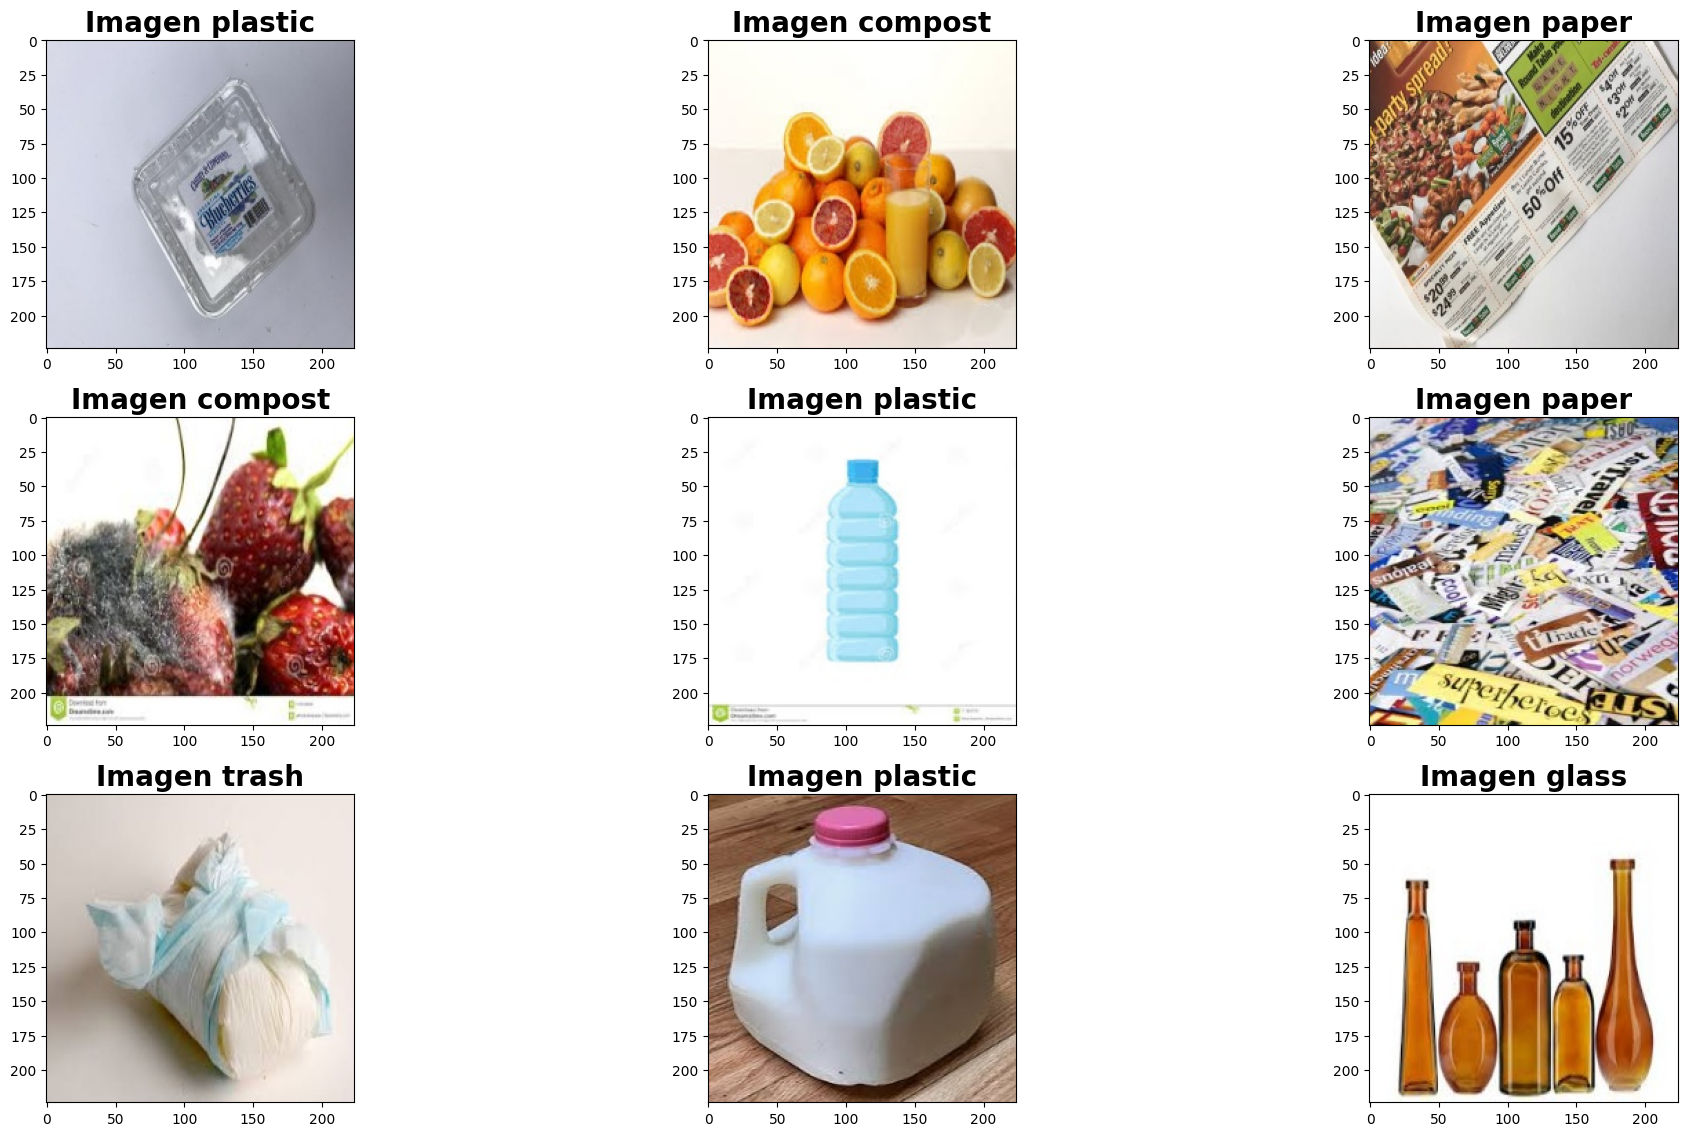

In [9]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(7000)
    plt.title('Imagen {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

Contamos el número de categorias de nuestro Dataset

In [10]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Número de clases : ",numberOfClass)

Número de clases :  7


## Construcción de un Modelo de Red Neuronal Convolucional (CNN) para Clasificación de Imágenes

Implementamos un modelo de red neuronal convolucional (CNN) utilizando la API de Keras dentro de TensorFlow, para la clasificación de imágenes. Comenzamos creando un modelo secuencial y añadimos múltiples capas convolucionales con activaciones ReLU, seguidas de capas de max pooling para reducir la dimensionalidad y prevenir el sobreajuste. Las salidas de las capas convolucionales las aplanamos antes de pasar a las capas densas, donde se aplica regularización L2 y Dropout para mejorar la generalización. Finalmente, definimos una capa de salida con activación softmax para manejar múltiples clases. El modelo lo compilamos utilizando la función de pérdida de entropía cruzada categórica y el optimizador Adam, estableciendo la precisión como métrica para evaluar su rendimiento.

In [14]:
# Creamos el modelo de tipo secuencial
model = Sequential()


# Primer capa convolucional

# Con "Conv2D(32,(3,3)" indicamos que se aplique una capa convolucional con 32 filtros (también llamados kernels) de tamaño 3x3.
# Con "Input_shape" indicamos que las imágenes de entrada tienen un tamaño de 224x224 píxeles y 3 canales (una imagen RGB con 3 canales de color: rojo, verde y azul).
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))

# Aplica la función de activación ReLU (Rectified Linear Unit), que introduce no linealidad en el modelo.
# ReLU convierte los valores negativos en 0, manteniendo los positivos tal cual.
model.add(Activation("relu"))

# Aplica una operación de max pooling, que reduce las dimensiones de las imágenes para disminuir la cantidad de parámetros y evitar el sobreajuste.
model.add(MaxPooling2D())


# Segunda capa convolucional

# Esta capa se aplica 64 filtros de tamaño 3x3. No se necesita especificar el input_shape porque la entrada a esta capa es la salida de la capa anterior.
model.add(Conv2D(64,(3,3)))

# Funcion de activacion igual a la capa anterior.
model.add(Activation("relu"))

# Igual que la capa anterior.
model.add(MaxPooling2D())


# Tercera capa convolucional

# Se aplica 128 filtros de tamaño 3x3.
model.add(Conv2D(128,(3,3)))

model.add(Conv2D(64, (3, 3)))  # Aumentar de 32 a 64 filtros
model.add(Conv2D(128, (3, 3)))  # Aumentar de 64 a 128 filtros

#Igual a las capas anteriores
model.add(Activation("relu"))

#Igual a las capas anteriores
model.add(MaxPooling2D())


# Aplanado de los datos (Flatten)

# Esta capa convierte la salida 3D de las capas convolucionales (ancho, alto, profundidad) en una dimensión 1D.
# Esto es necesario para conectar las capas convolucionales con las capas completamente conectadas (densas) que vienen a continuación.
model.add(Flatten())

# Primera capa completamente conectada (Dense)

# Agrega una capa densa completamente conectada con 256 neuronas.
#model.add(Dense(256))

#Aparte del Dropout, puedes añadir regularización L2 en las capas densas para reducir el riesgo de sobreajuste:
model.add(Dense(256, kernel_regularizer=l2(0.01)))  # Añadir regularización L2


# Aplica la activación ReLU para introducir no linealidad.
model.add(Activation("relu"))

# Aplica la técnica de Dropout, que desactiva aleatoriamente el 50% de las neuronas durante el entrenamiento.
# Esto ayuda a prevenir el sobreajuste, forzando al modelo a generalizar mejor.
model.add(Dropout(0.5))

# Segunda capa completamente conectada (Dense)

# Similar a la capa anterior
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))


# Capa de salida

# La última capa densa tiene tantas neuronas como el número de clases en el problema de clasificación (numberOfClass).
# Cada neurona corresponde a una clase diferente.
model.add(Dense(numberOfClass)) # output

# Utiliza la activación sigmoide, que es adecuada para problemas de clasificación binaria o multiclase con una sola etiqueta.
# La activación sigmoide convierte las salidas en valores entre 0 y 1.
model.add(Activation("softmax"))


# Compilación del modelo
model.compile(loss = "sparse_categorical_crossentropy", #  "categorical_crossentropy", # si las etiquetas no están en one-hot,  función de pérdida es entropía cruzada binaria. Esto sugiere que el problema es de clasificación binaria (dos clases).
              optimizer = "adam", # Utiliza el optimizador Adam para el ajuste automático de los parámetros de entrenamiento.
              metrics = ["sparse_categorical_accuracy"])  #["accuracy"])  # Se utiliza la métrica de precisión (accuracy) para evaluar el rendimiento del modelo durante el entrenamiento.

# Tamaño de lote (batch size)
# Define el tamaño del lote para el entrenamiento, es decir, el número de muestras que el modelo procesará antes de actualizar los pesos.
# En este caso, el lote es de 256 muestras.
batch_size =64 # 64 # 128  # 256



I0000 00:00:1730044320.035801     970 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-27 12:52:00.358178: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 Representación gráfica de la arquitectura del modelo (con las capas y sus conexiones).

In [13]:
#plot_model(model)

In [14]:
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


Creamos un objeto de la clase ImageDataGenerator de Keras, que se utilizara para generar lotes de imágenes preprocesadas en tiempo real durante el entrenamiento de un modelo de deep learning. Este generador aplica transformaciones o modificaciones a las imágenes de entrada, como el escalado, la normalización, rotación, el desplazamiento, entre otras.
Utilizamos antes de entrenar el modelo para mejorar la eficacia y velocidad del entrenamiento.

 "rescale" escalamos los valores de los píxeles de las imágenes.
 Las imágenes generalmente tienen valores de píxel en el rango [0, 255] (dado que los píxeles tienen valores RGB).
 Al establecer rescale=1./255, estás normalizando los valores de los píxeles al rango [0, 1]. Esto se logra dividiendo cada valor de píxel por 255.

In [15]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [16]:
test_datagen = ImageDataGenerator(rescale= 1./255)

Creamos un generador de imágenes a partir de un conjunto de imágenes almacenadas en carpetas, utilizando el método flow_from_directory() del objeto ImageDataGenerator (en este caso, train_datagen). El generador producirá lotes de imágenes que se pueden utilizar para entrenar el modelo de red neuronal convolucional (CNN).

In [17]:

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical"
    #,
        #rotation_range=30, 
#width_shift_range=0.2,
#height_shift_range=0.2,
#shear_range=0.2,
#zoom_range=0.2,
#horizontal_flip=True
)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size= (224,224),
        batch_size = 8  # batch_size,
        color_mode= "rgb",
        shuffle=false,  
        class_mode= "categorical"
)

Found 7110 images belonging to 7 classes.
Found 644 images belonging to 7 classes.


In [18]:
import tensorflow as tf

# Verifica las GPUs disponibles
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detectadas: {len(gpus)}")
    for gpu in gpus:
        print(gpu)
else:
    print("No se detectó ninguna GPU.")


No se detectó ninguna GPU.


In [19]:
print(data.shape)


(7117, 2)


Entrenamos el modelo ajustandolo a los datos de entrenamiento.

In [20]:
#inicio 15:26hs
hist = model.fit(
    train_generator,  # Ya no se necesita el argumento 'generator'
    epochs=20,
    validation_data=test_generator
)


Epoch 1/20


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 7), output.shape=(None, 7)

Gráfico de Precisión durante el Entrenamiento y Validación del Modelo

Mostramos la evolución de la precisión (accuracy) a lo largo del proceso de entrenamiento y validación de un modelo de aprendizaje automático. Utilizando los datos almacenados en hist.history, trazamos dos curvas: una para la precisión del conjunto de entrenamiento y otra para la precisión del conjunto de validación. Este gráfico es útil para evaluar el desempeño del modelo y diagnosticar posibles problemas de sobreajuste (overfitting) o subajuste (underfitting), al comparar cómo cambia la precisión en cada época para ambos conjuntos.

Curvas similares: Indican un buen ajuste o un posible subajuste, dependiendo de los niveles de precisión alcanzados.     
Curvas separadas: Indican un posible sobreajuste, donde el modelo no generaliza bien a datos nuevos.

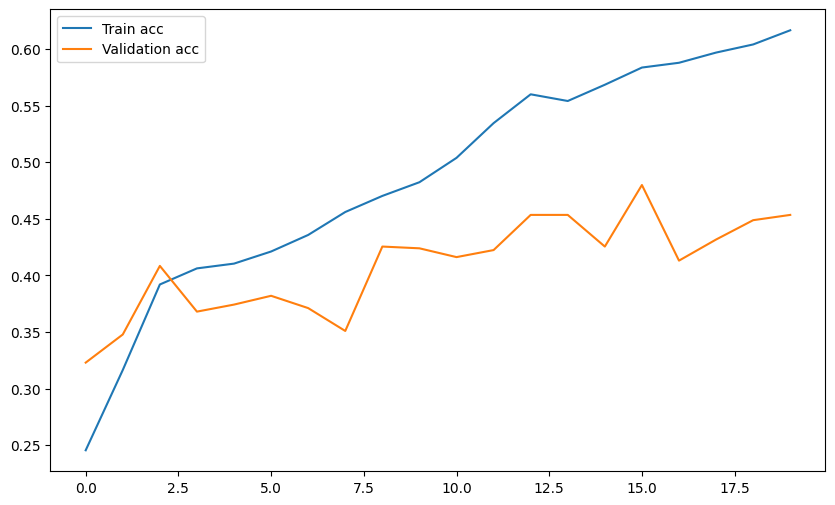

In [17]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

Gráfico de Pérdida durante el Entrenamiento y Validación del Modelo

Muestra la evolución de la pérdida (loss) durante el proceso de entrenamiento y validación de un modelo de aprendizaje automático. Utilizando el historial de pérdidas almacenado en hist.history, se trazan dos curvas: una para la pérdida en el conjunto de entrenamiento y otra para la pérdida en el conjunto de validación. El gráfico permite visualizar cómo varían estos valores a lo largo de las épocas y es útil para diagnosticar posibles problemas de sobreajuste o subajuste en el modelo.

Curvas similares: indican buen ajuste o subajuste (dependiendo del valor de la pérdida).                             
Curvas separadas: indican posible sobreajuste (el modelo no generaliza bien).

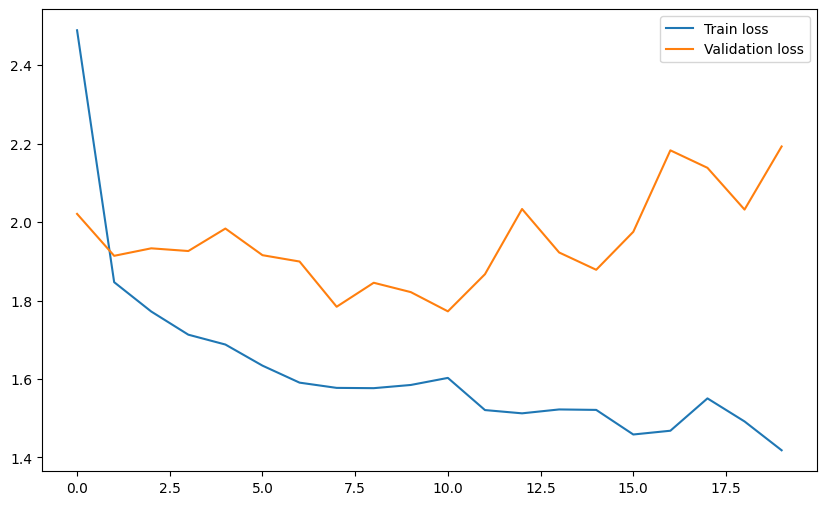

In [18]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

Visualización de Predicciones del Modelo en un Conjunto de Datos de Prueba

Evaluamos el rendimiento del modelo de aprendizaje automático al visualizar sus predicciones sobre un lote de imágenes de prueba. Obtenemos un conjunto de imágenes y sus etiquetas correspondientes del generador de datos de prueba. A continuación, realizamos predicciones utilizando el modelo y se muestra un gráfico que presenta las imágenes junto con sus predicciones y las etiquetas verdaderas. Cada imagen en el gráfico incluye un título que indica la clase predicha por el modelo y la clase real. Esta visualización es útil para diagnosticar el desempeño del modelo y observar ejemplos específicos de aciertos y errores en la clasificación.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


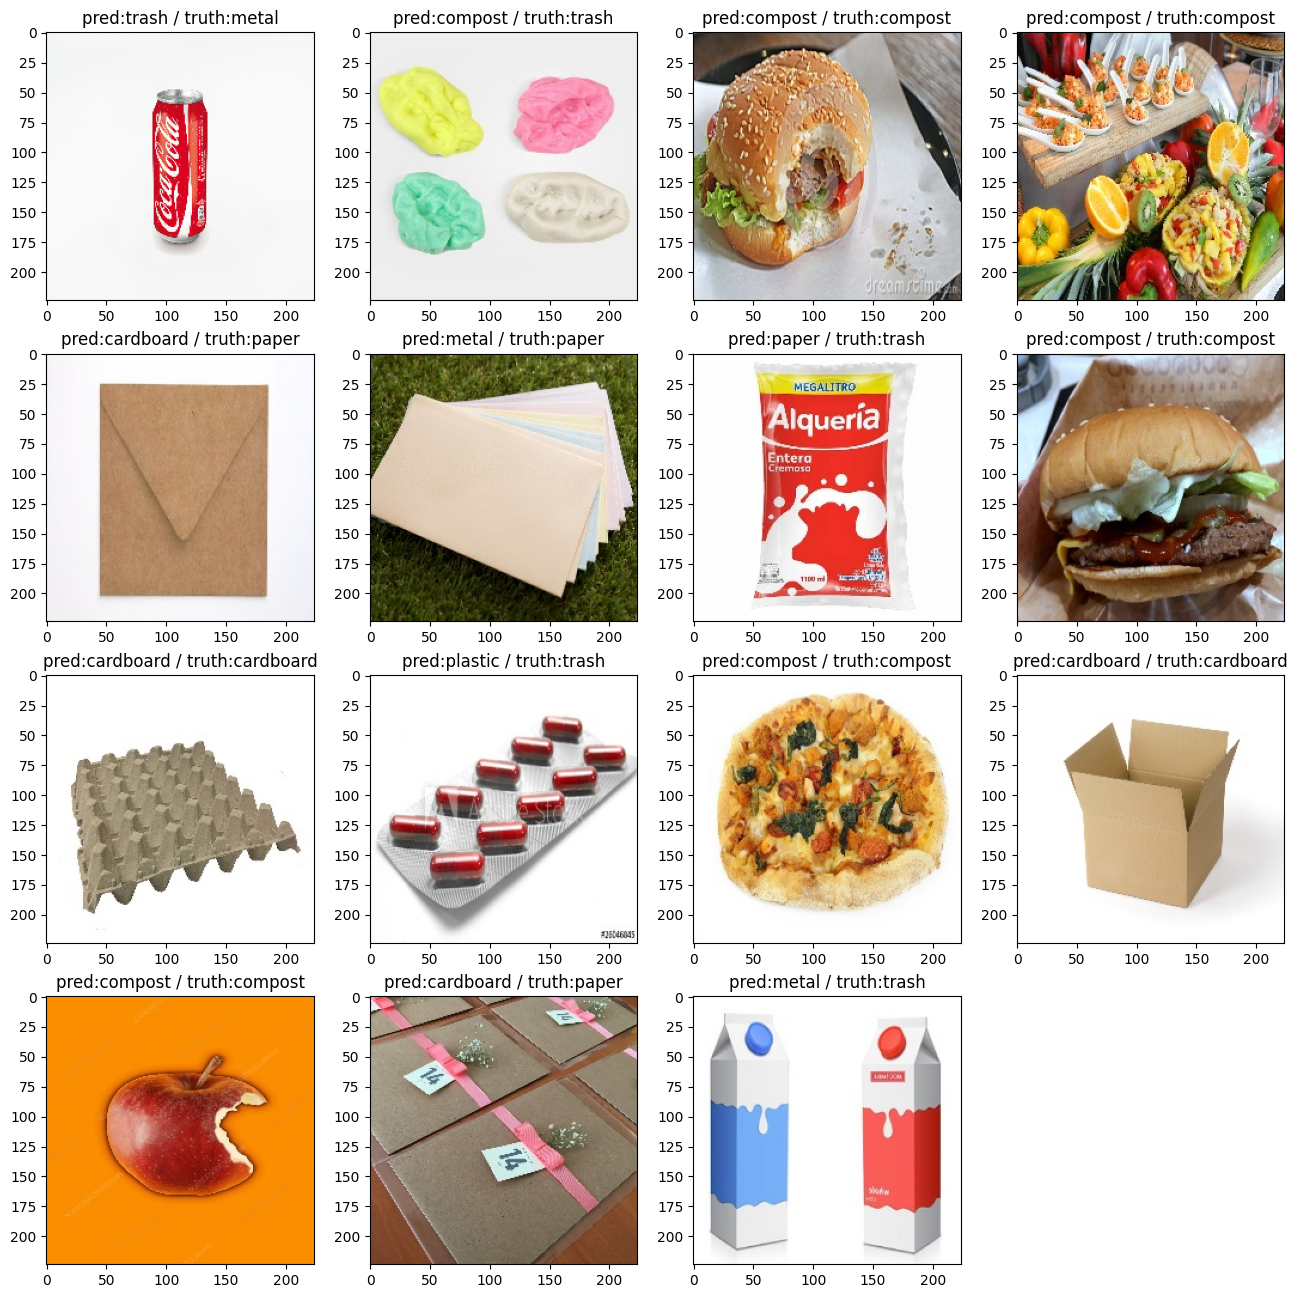

In [19]:
test_x, test_y = test_generator.__getitem__(1)

labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(15):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

# Guardamos el modelo 🎓

In [20]:
model.save('/mnt/c/Users/edgardo/git-edgardo/Austral/TF-Diplo/Tensorflow/model_NoHayPlanetaB_tf.keras')